## Model Selection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
dummy = pd.read_csv('../../datasets/pymc/s/pymc/dummy.csv', names=['x', 'y'])
dummy.head()

,x,y
0,-1.081,9.357
1,-0.888,8.322
2,-0.623,8.745
3,-0.480,7.346
4,-0.505,7.028


In [4]:
x_1 = dummy['x']
y_1 = dummy['y']

x_1p = np.vstack([x_1.pow(i) for i in range(1, 3)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))
x_1s.shape

(2, 33)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

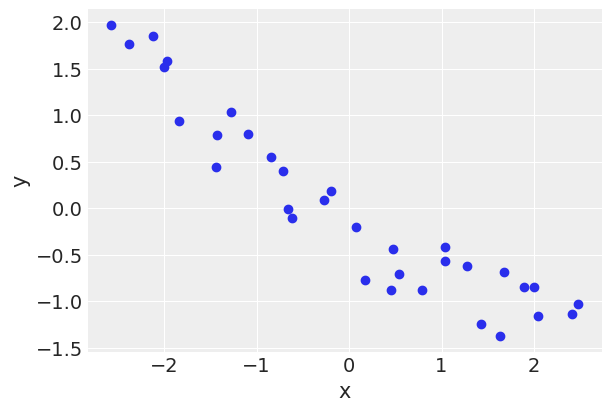

In [5]:
x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

_, ax = plt.subplots(figsize=(6, 4))

ax.scatter(x_1s[0], y_1s)
ax.set(xlabel='x', ylabel='y')

In [6]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    # trace_l = pm.sample(2000, return_inferencedata=True)
    # trace_l.to_netcdf("data/ch5/lr_l.nc")
    trace_l = az.from_netcdf("../../datasets/pymc/ch5/lr_l.nc")

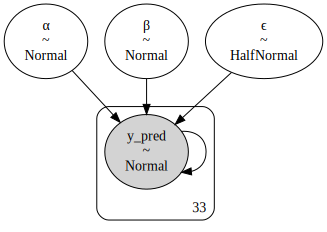

In [7]:
pm.model_to_graphviz(model_l)

In [8]:
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    # trace_p = pm.sample(2000, return_inferencedata=True)
    # trace_p.to_netcdf("data/ch5/lr_p.nc")
    trace_p = az.from_netcdf("../../datasets/pymc/ch5/lr_p.nc")

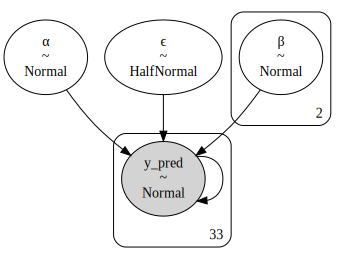

In [9]:
pm.model_to_graphviz(model_p)

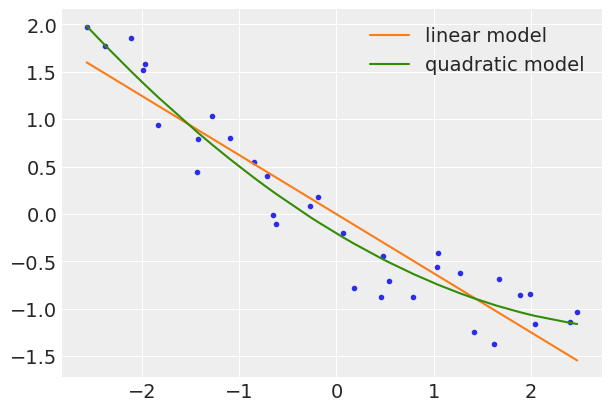

In [10]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l.posterior['α'].mean(axis=0).mean(axis=0).values
β_l_post = trace_l.posterior['β'].mean(axis=0)[1].values
y_l_post = α_l_post + β_l_post * x_new

α_p_post = trace_p.posterior['α'].mean(axis=0).mean(axis=0).values
β_p_post = trace_p.posterior['β'].mean(axis=0)[1].values
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

_, ax = plt.subplots(figsize=(6, 4))

ax.plot(x_new, y_l_post, 'C1', label='linear model')
ax.plot(x_1s[0][idx], y_p_post[idx], 'C2', label='quadratic model')
ax.scatter(x_1s[0], y_1s, c='C0', marker='.')
ax.legend()
# plt.savefig('images/ch5/dummy_fit.png')

## Posterior predictive checks

In [11]:
y_l = pm.sample_posterior_predictive(trace_l, 2000,
                                     model=model_l)['y_pred']

y_p = pm.sample_posterior_predictive(trace_p, 2000,
                                     model=model_p)['y_pred']

IncorrectArgumentsError: Should not specify both keep_size and samples arguments. See the docstring of the samples argument for more details.

[(-2.5, 0.5), []]

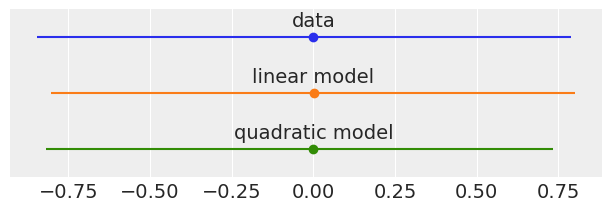

In [ ]:
_, ax = plt.subplots(figsize=(6, 2))

data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'quadratic model']

for i, (d, label) in enumerate(zip(data, labels)):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    ax.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    ax.text(mean, -i + 0.2, label, ha='center', fontsize='medium')

ax.set(ylim=[-i - 0.5, 0.5], yticks=[])
# plt.savefig('images/ch5/dummy_iqr.png')

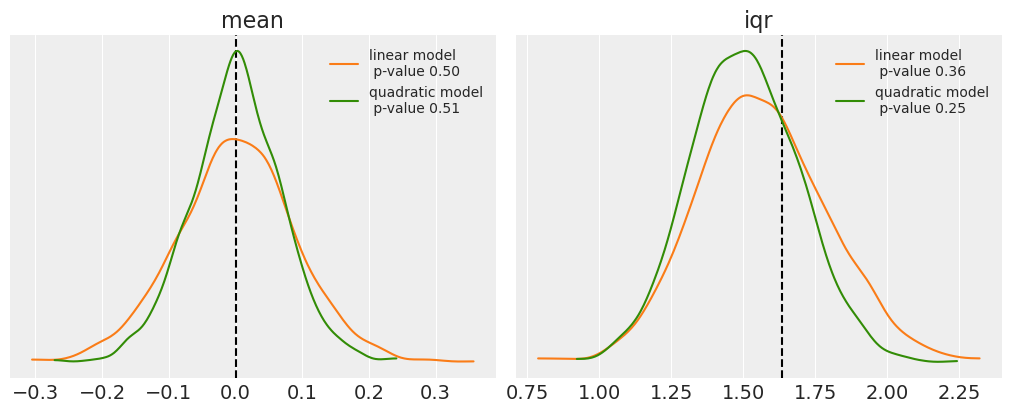

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10, 4),  constrained_layout=True)


def iqr(x, axis=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis))


funcs = [np.mean, iqr]
ys = [y_l, y_p]
models = ['linear model', 'quadratic model']
colors = ['C1', 'C2']

for ax, func in zip(axes, funcs):
    T_obs = func(y_1s, axis=0)
    ax.axvline(T_obs, 0, 1, color='k', ls='--')

    for d_sim, model, c in zip(ys, models, colors):
        T_sim = func(d_sim, axis=1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim,
                    plot_kwargs={'color': c},
                    label=f'{model}\n p-value {p_value:.2f}',
                    ax=ax)
    ax.set(title=func.__name__, yticks=[])
    ax.legend(loc=1, fontsize='medium')

# plt.savefig('images/ch5/dummy_mean_iqr.png')

## Occam's razor

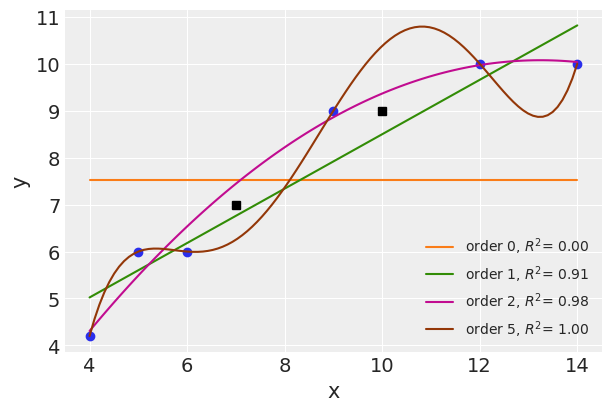

In [ ]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

_, ax = plt.subplots(figsize=(6, 4))

order = [0, 1, 2, 5]
ax.plot(x, y, 'o')

for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)

    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat - ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot

    ax.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

ax.legend(loc=4, fontsize='medium')
ax.set(xlabel='x', ylabel='y')
ax.plot([10, 7], [9, 7], 'ks')
# plt.savefig('images/ch5/occam.png')

### Information criteria

In [ ]:
waic_l = az.waic(trace_l)
waic_l

Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -13.89     2.66
p_waic        2.47        -

In [ ]:
cmp_df = az.compare({
    'model_l': trace_l,
    'model_p': trace_p
},
                    ic='waic',
                    scale='deviance',
                    method='BB-pseudo-BMA')
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_p,0,8.169479,2.649600,0.000000,0.998725,5.106760,0.000000,False,deviance
model_l,1,27.770222,2.467228,19.600744,0.001275,4.666062,5.295112,False,deviance


<AxesSubplot:xlabel='Deviance'>

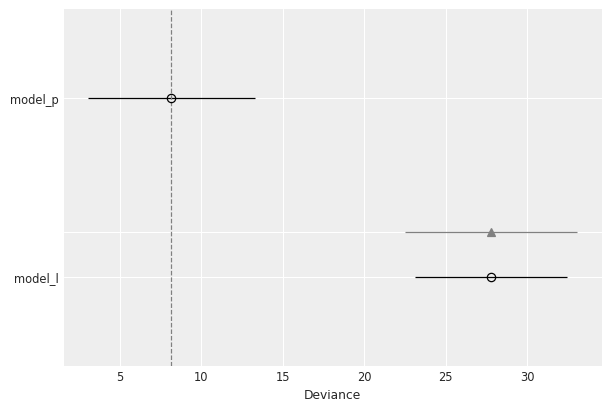

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

az.plot_compare(cmp_df, insample_dev=False, ax=ax)
# plt.savefig('images/ch5/waic_comparison.png')

### Model Averaging

In [ ]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p],
                                        samples=1000,
                                        models=[model_l, model_p],
                                        weights=[w, 1-w])

NotImplementedError: 

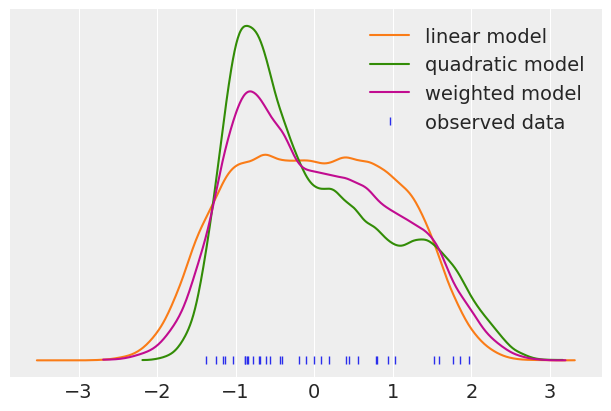

In [ ]:
_, ax = plt.subplots(figsize=(6, 4))

az.plot_kde(y_l, plot_kwargs={'color': 'C1'}, label='linear model', ax=ax)
az.plot_kde(y_p, plot_kwargs={'color': 'C2'}, label='quadratic model', ax=ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
           label='weighted model', ax=ax)

ax.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
ax.set(yticks=[])
ax.legend()
# plt.savefig('images/ch5/averaging.png')

## Bayes factors

In [ ]:
coins = 30 # 300
heads = 9 # 90
y_d = np.repeat([0, 1], [coins-heads, heads])

In [ ]:
with pm.Model() as model_bf:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)

    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    θ = pm.Beta('θ', m[0], m[1])
    y = pm.Bernoulli('y', θ, observed=y_d)

    # trace_bf = pm.sample(5000, return_inferencedata=True)
    # trace_bf.to_netcdf("data/ch5/coin_bf.nc")
    trace_bf = az.from_netcdf("../../datasets/pymc/ch5/coin_bf.nc")

array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

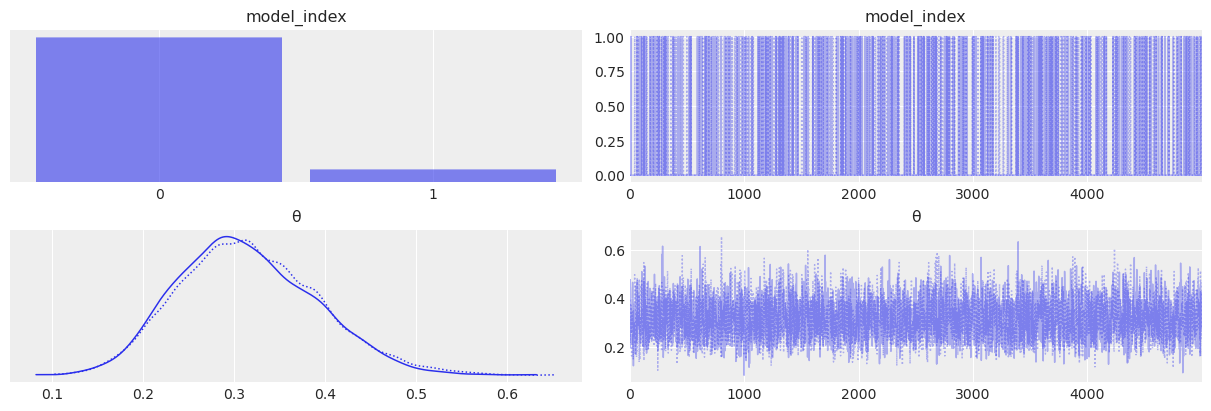

In [ ]:
az.plot_trace(trace_bf)

In [ ]:
pM1 = trace_bf.posterior['model_index'].mean()
pM0 = 1 - pM1
bf = (pM0 / pM1) * (p[1] / p[0])

In [ ]:
with pm.Model() as model_bf_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_bf_0= pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/kaggle/lib/python3.9/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


NameError: name 'HTML' is not defined

In [ ]:
with pm.Model() as model_bf_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_bf_1 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.201
Stage:   1 Beta: 0.652
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.207
Stage:   1 Beta: 0.688
Stage:   2 Beta: 1.000


In [ ]:
trace_bf_0.report.log_marginal_likelihood / trace_bf_1.report.log_marginal_likelihood

array([0.88717108, 0.88650376])

### with information criteria

In [ ]:
traces = []
waics = []
ind = 1
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4, 8), (8, 4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            # trace = pm.sample(2000, return_inferencedata=True)
            # trace.to_netcdf(f'data/ch5/bf_{ind}.nc')
            trace = az.from_netcdf(f'data/ch5/bf_{ind}.nc')
            traces.append(trace)
            waics.append(az.waic(trace, scale='deviance'))
            ind += 1

In [ ]:
pd.DataFrame(waics)

,waic,waic_se,p_waic,n_samples,n_data_points,warning,waic_scale
0,38.172441,4.307955,0.756283,4000,30,False,deviance
1,39.483366,2.012406,0.691197,4000,30,False,deviance
2,368.366197,13.460998,0.922967,4000,300,False,deviance
3,368.741083,12.464661,0.965218,4000,300,False,deviance


In [ ]:
pd.DataFrame(waics).to_markdown()

'|    |     waic |   waic_se |   p_waic |   n_samples |   n_data_points | warning   | waic_scale   |\n|---:|---------:|----------:|---------:|------------:|----------------:|:----------|:-------------|\n|  0 |  38.1724 |   4.30795 | 0.756283 |        4000 |              30 | False     | deviance     |\n|  1 |  39.4834 |   2.01241 | 0.691197 |        4000 |              30 | False     | deviance     |\n|  2 | 368.366  |  13.461   | 0.922967 |        4000 |             300 | False     | deviance     |\n|  3 | 368.741  |  12.4647  | 0.965218 |        4000 |             300 | False     | deviance     |'

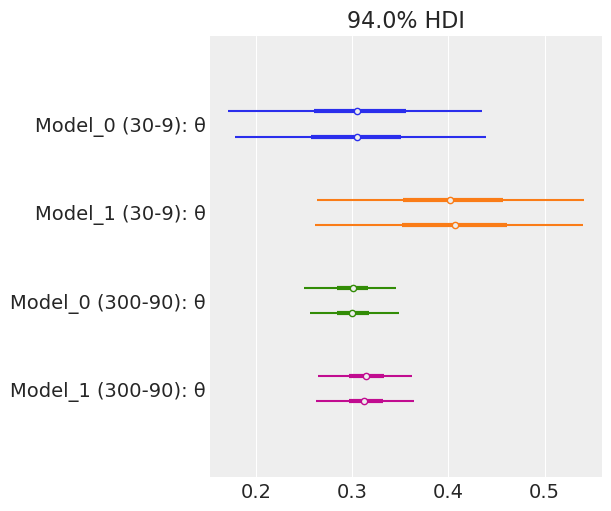

In [ ]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

_, ax = plt.subplots(figsize=(6, 5))

az.plot_forest(traces, model_names=model_names, ax=ax)
# plt.savefig('images/ch5/coin_bf_forest.png')

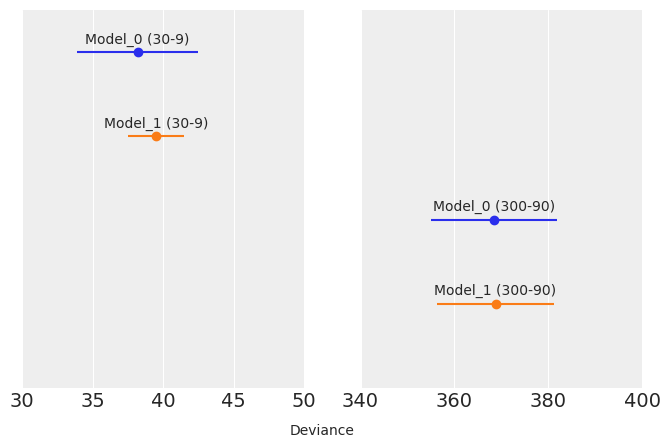

In [ ]:
fig, axes = plt.subplots(1,
                         2,
                         figsize=(8, 5),
                         
                         sharey=True,
                         constrained_layout=False)

indices = [0, 0, 1, 1]

for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    axes[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    axes[ind].text(mean, -i + 0.1, model_names[i], ha='center')

axes[0].set(xlim=(30, 50), yticks=[], ylim=[-4, 0.5])
axes[1].set(xlim=(340, 400))
plt.subplots_adjust(wspace=0.2)
fig.text(0.5, 0.03, 'Deviance', ha='center', fontsize='medium')
# plt.savefig('images/ch5/coin_bf_iqr.png')